# Detecting Pneumonia using Convolutional Neural Network (CNN)

## Import The Required Libraries

In [128]:
# basics
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

import pickle 

# Keras Libraries
import keras
import tensorflow as tf
from keras import backend as K
from keras import metrics
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.metrics import AUC
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import keras.backend


In [132]:
# Set a seed value
seed_value= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.set_random_seed(seed_value)

# 5. For layers that introduce randomness like dropout, make sure to set seed values 
#model.add(Dropout(0.25, seed=seed_value))

#6 Configure a new global `tensorflow` session
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [14]:
project_path = "/Users/hellojenny/Metis/Metis-Bootcamp/Projects/Project 5 - Image Prediction using CNN"
train_path = project_path + "/chest_xray/train/"
val_path = project_path + "/chest_xray/val/"
test_path = project_path + "/chest_xray/test/"

In [15]:
hyper_dimension = 64
hyper_batch_size = 128
hyper_epochs = 100

## Training in grayscale instead of RGB
hyper_channels = 1
hyper_mode = 'grayscale'

In [16]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0) 
test_datagen = ImageDataGenerator(rescale=1.0/255.0) 


train_generator = train_datagen.flow_from_directory(directory = train_path, 
                                                    target_size = (hyper_dimension, hyper_dimension),
                                                    batch_size = hyper_batch_size, 
                                                    color_mode = hyper_mode,
                                                    class_mode = 'binary', 
                                                    seed = 42)
val_generator = val_datagen.flow_from_directory(directory = val_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)
test_generator = test_datagen.flow_from_directory(directory = test_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)

test_generator.reset()

Found 4139 images belonging to 2 classes.
Found 1093 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Top 3 Models

We first created a function to create two charts that shows the progress of training the neural network.

In [107]:
def create_charts(cnn, cnn_model):
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[3]
    val_auc_name = list(cnn_model.history.keys())[1]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Pneumonia']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    ;
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

### Model #1: Conv2D x 3 + 64 dense units

In [133]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))
                                
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=64))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=1)


Epoch 1/100
33/33 [==============================] - 49s 1s/step - loss: 0.5372 - auc_17: 0.4812 - val_loss: 0.2767 - val_auc_17: 0.7708
Epoch 2/100
33/33 [==============================] - 49s 1s/step - loss: 0.4945 - auc_17: 0.6610 - val_loss: 0.2276 - val_auc_17: 0.9282
Epoch 3/100
33/33 [==============================] - 49s 1s/step - loss: 0.3529 - auc_17: 0.9020 - val_loss: 0.1062 - val_auc_17: 0.9503
Epoch 4/100
33/33 [==============================] - 45s 1s/step - loss: 0.2940 - auc_17: 0.9386 - val_loss: 0.2126 - val_auc_17: 0.9465
Epoch 5/100
33/33 [==============================] - 46s 1s/step - loss: 0.2819 - auc_17: 0.9407 - val_loss: 0.1442 - val_auc_17: 0.9596
Epoch 6/100
33/33 [==============================] - 45s 1s/step - loss: 0.2390 - auc_17: 0.9485 - val_loss: 0.1721 - val_auc_17: 0.9626
Epoch 7/100
33/33 [==============================] - 47s 1s/step - loss: 0.2099 - auc_17: 0.9568 - val_loss: 0.2045 - val_auc_17: 0.9659
Epoch 8/100
33/33 [======================

TypeError: create_charts() missing 1 required positional argument: 'cnn_model'

[Summary Statistics]
Accuracy = 89.10% | Precision = 85.78% | Recall = 98.97% | Specificity = 72.65% | F1 Score = 91.90%


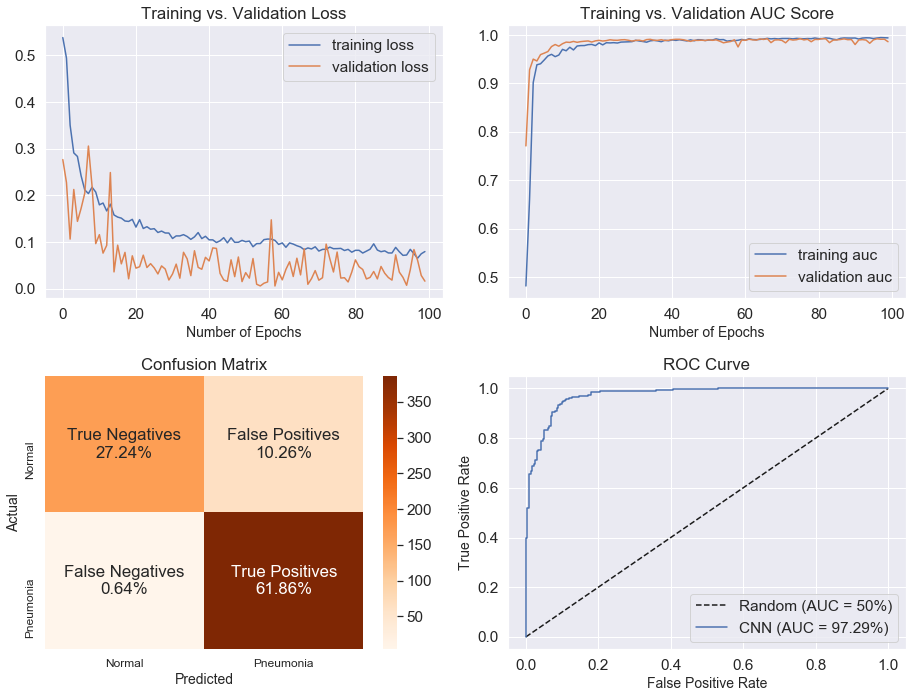

In [135]:
create_charts(cnn, cnn_model)

### Model #2: Conv2D x 4 + 64 dense units

Epoch 1/100
33/33 [==============================] - 49s 1s/step - loss: 0.5609 - auc_7: 0.5007 - val_loss: 0.2178 - val_auc_7: 0.5265
Epoch 2/100
33/33 [==============================] - 40s 1s/step - loss: 0.5135 - auc_7: 0.5512 - val_loss: 0.1702 - val_auc_7: 0.7728
Epoch 3/100
33/33 [==============================] - 40s 1s/step - loss: 0.4690 - auc_7: 0.7200 - val_loss: 0.1898 - val_auc_7: 0.9365
Epoch 4/100
33/33 [==============================] - 40s 1s/step - loss: 0.3454 - auc_7: 0.8814 - val_loss: 0.2801 - val_auc_7: 0.9555
Epoch 5/100
33/33 [==============================] - 39s 1s/step - loss: 0.2706 - auc_7: 0.9300 - val_loss: 0.0594 - val_auc_7: 0.9675
Epoch 6/100
33/33 [==============================] - 39s 1s/step - loss: 0.2597 - auc_7: 0.9348 - val_loss: 0.1179 - val_auc_7: 0.9490
Epoch 7/100
33/33 [==============================] - 39s 1s/step - loss: 0.2471 - auc_7: 0.9391 - val_loss: 0.0766 - val_auc_7: 0.9619
Epoch 8/100
33/33 [==============================] - 40

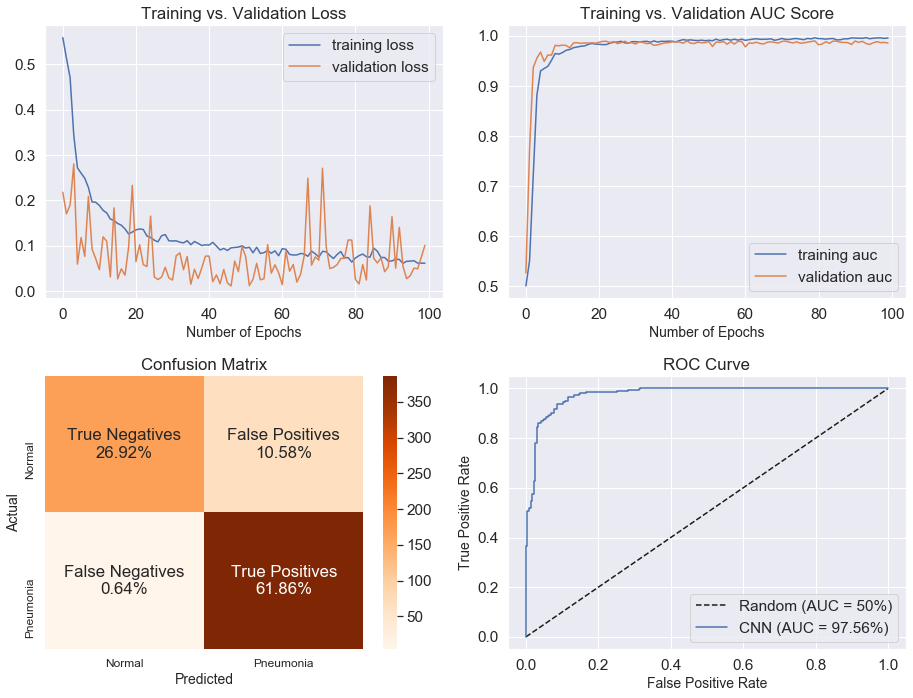

In [105]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=64))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator))

[Summary Statistics]
Accuracy = 83.33% | Precision = 79.55% | Recall = 98.72% | Specificity = 57.69% | F1 Score = 88.10%


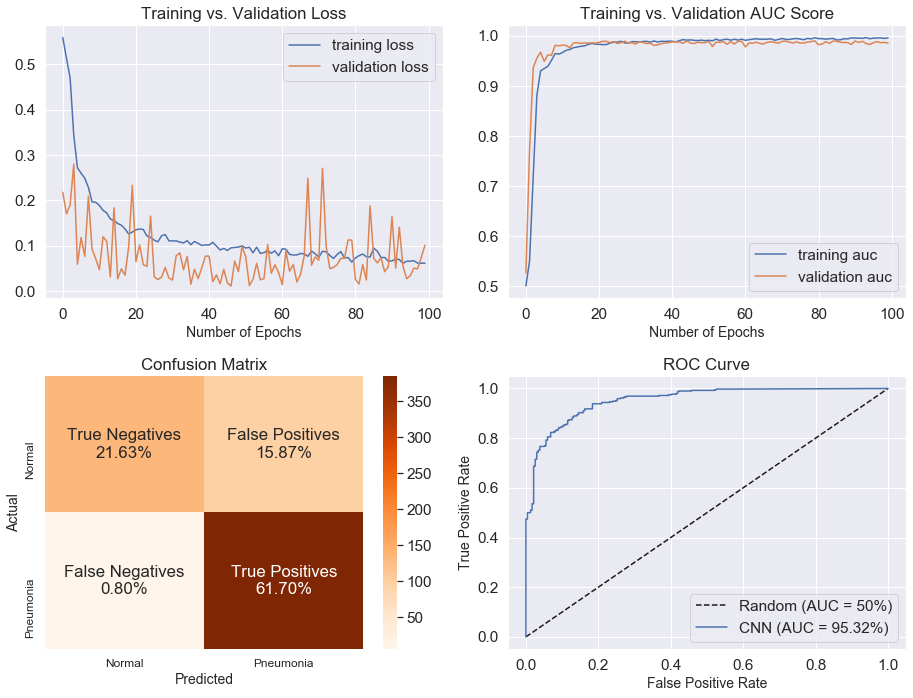

In [109]:
create_charts(cnn, cnn_model)

### Model #3: Conv2D x 2 + 64 dense units

In [110]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=64))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

Epoch 1/100
 - 37s - loss: 0.5203 - auc_9: 0.5485 - val_loss: 0.4263 - val_auc_9: 0.9537
Epoch 2/100
 - 36s - loss: 0.4087 - auc_9: 0.8275 - val_loss: 0.2327 - val_auc_9: 0.9683
Epoch 3/100
 - 37s - loss: 0.3398 - auc_9: 0.9000 - val_loss: 0.0918 - val_auc_9: 0.9720
Epoch 4/100
 - 38s - loss: 0.2716 - auc_9: 0.9519 - val_loss: 0.1443 - val_auc_9: 0.9604
Epoch 5/100
 - 36s - loss: 0.2558 - auc_9: 0.9548 - val_loss: 0.0611 - val_auc_9: 0.9785
Epoch 6/100
 - 37s - loss: 0.2588 - auc_9: 0.9549 - val_loss: 0.1002 - val_auc_9: 0.9747
Epoch 7/100
 - 40s - loss: 0.2493 - auc_9: 0.9634 - val_loss: 0.1910 - val_auc_9: 0.9585
Epoch 8/100
 - 40s - loss: 0.2413 - auc_9: 0.9625 - val_loss: 0.0988 - val_auc_9: 0.9744
Epoch 9/100
 - 38s - loss: 0.2424 - auc_9: 0.9613 - val_loss: 0.1361 - val_auc_9: 0.9759
Epoch 10/100
 - 41s - loss: 0.2247 - auc_9: 0.9709 - val_loss: 0.1068 - val_auc_9: 0.9712
Epoch 11/100
 - 39s - loss: 0.2279 - auc_9: 0.9684 - val_loss: 0.0484 - val_auc_9: 0.9843
Epoch 12/100
 - 41s

 - 39s - loss: 0.0797 - auc_9: 0.9953 - val_loss: 0.0846 - val_auc_9: 0.9927
Epoch 93/100
 - 39s - loss: 0.0854 - auc_9: 0.9946 - val_loss: 0.0442 - val_auc_9: 0.9861
Epoch 94/100
 - 39s - loss: 0.0763 - auc_9: 0.9956 - val_loss: 0.0355 - val_auc_9: 0.9875
Epoch 95/100
 - 39s - loss: 0.0771 - auc_9: 0.9956 - val_loss: 0.0955 - val_auc_9: 0.9878
Epoch 96/100
 - 39s - loss: 0.0768 - auc_9: 0.9965 - val_loss: 0.0724 - val_auc_9: 0.9911
Epoch 97/100
 - 39s - loss: 0.0701 - auc_9: 0.9956 - val_loss: 0.1124 - val_auc_9: 0.9916
Epoch 98/100
 - 39s - loss: 0.0847 - auc_9: 0.9949 - val_loss: 0.0467 - val_auc_9: 0.9909
Epoch 99/100
 - 39s - loss: 0.0783 - auc_9: 0.9959 - val_loss: 0.0532 - val_auc_9: 0.9910
Epoch 100/100
 - 39s - loss: 0.0793 - auc_9: 0.9949 - val_loss: 0.0771 - val_auc_9: 0.9918


[Summary Statistics]
Accuracy = 90.87% | Precision = 88.63% | Recall = 97.95% | Specificity = 79.06% | F1 Score = 93.06%


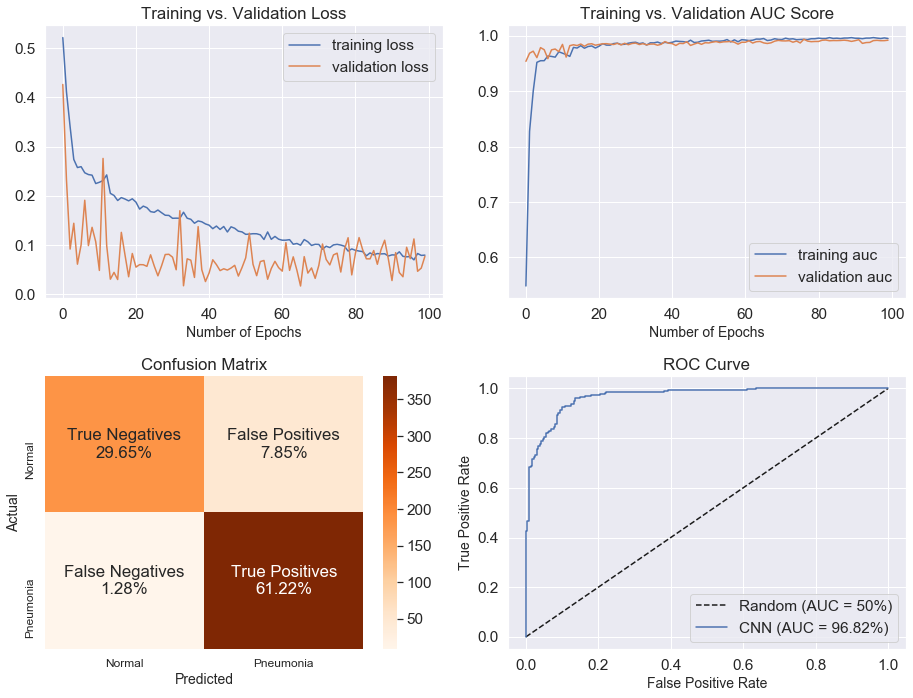

In [111]:
create_charts(cnn, cnn_model)

### Model #4 (I): Conv2D x 3 + 128 dense units (100 epochs)

In [125]:
# Conv2D x 3 + 128 dense units
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

Epoch 1/100


KeyboardInterrupt: 

[Summary Statistics]
Accuracy = 89.74% | Precision = 87.73% | Recall = 97.18% | Specificity = 77.35% | F1 Score = 92.21%


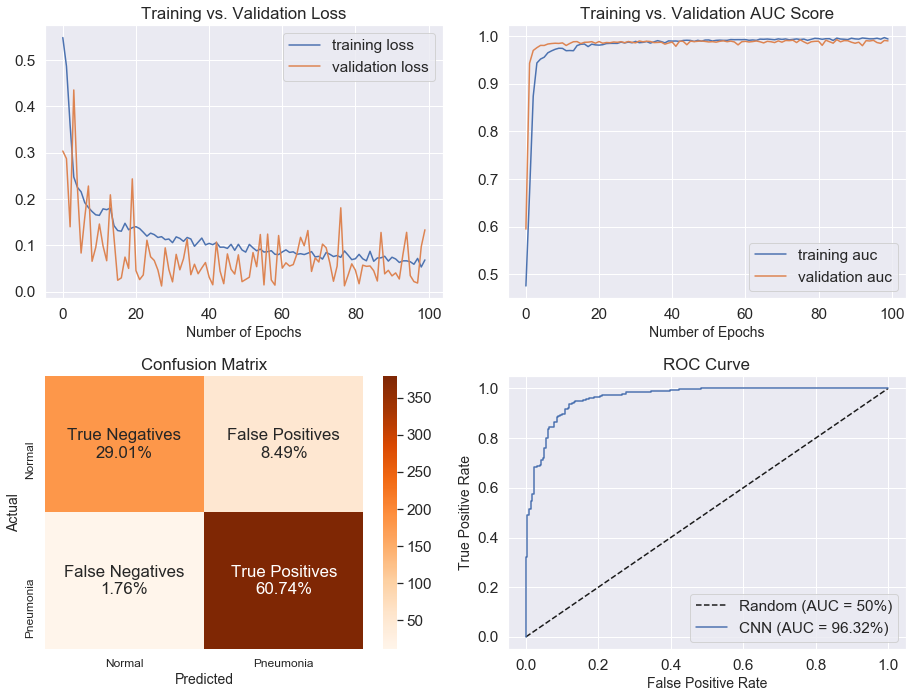

In [114]:
create_charts(cnn, cnn_model)

### Model #4 (II): Conv2D x 3 + 128 dense units (200 epochs)

In [121]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 200, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

Epoch 1/200
 - 42s - loss: 0.5274 - auc_13: 0.5134 - val_loss: 0.3126 - val_auc_13: 0.8519
Epoch 2/200
 - 43s - loss: 0.4469 - auc_13: 0.7696 - val_loss: 0.1330 - val_auc_13: 0.9561
Epoch 3/200
 - 44s - loss: 0.2900 - auc_13: 0.9205 - val_loss: 0.3439 - val_auc_13: 0.9717
Epoch 4/200
 - 43s - loss: 0.2426 - auc_13: 0.9418 - val_loss: 0.2222 - val_auc_13: 0.9736
Epoch 5/200
 - 42s - loss: 0.2203 - auc_13: 0.9533 - val_loss: 0.2285 - val_auc_13: 0.9761
Epoch 6/200
 - 42s - loss: 0.2133 - auc_13: 0.9571 - val_loss: 0.2454 - val_auc_13: 0.9796
Epoch 7/200
 - 42s - loss: 0.2039 - auc_13: 0.9613 - val_loss: 0.2404 - val_auc_13: 0.9824
Epoch 8/200
 - 42s - loss: 0.1932 - auc_13: 0.9648 - val_loss: 0.1151 - val_auc_13: 0.9826
Epoch 9/200
 - 42s - loss: 0.1838 - auc_13: 0.9681 - val_loss: 0.0617 - val_auc_13: 0.9842
Epoch 10/200
 - 42s - loss: 0.1787 - auc_13: 0.9698 - val_loss: 0.1722 - val_auc_13: 0.9856
Epoch 11/200
 - 42s - loss: 0.1759 - auc_13: 0.9710 - val_loss: 0.1332 - val_auc_13: 0.98

Epoch 91/200
 - 41s - loss: 0.0678 - auc_13: 0.9942 - val_loss: 0.0542 - val_auc_13: 0.9919
Epoch 92/200
 - 40s - loss: 0.0707 - auc_13: 0.9939 - val_loss: 0.0420 - val_auc_13: 0.9915
Epoch 93/200
 - 41s - loss: 0.0710 - auc_13: 0.9950 - val_loss: 0.0702 - val_auc_13: 0.9921
Epoch 94/200
 - 41s - loss: 0.0671 - auc_13: 0.9951 - val_loss: 0.0314 - val_auc_13: 0.9892
Epoch 95/200
 - 41s - loss: 0.0695 - auc_13: 0.9947 - val_loss: 0.0709 - val_auc_13: 0.9925
Epoch 96/200
 - 40s - loss: 0.0610 - auc_13: 0.9959 - val_loss: 0.0382 - val_auc_13: 0.9925
Epoch 97/200
 - 40s - loss: 0.0678 - auc_13: 0.9946 - val_loss: 0.0235 - val_auc_13: 0.9907
Epoch 98/200
 - 41s - loss: 0.0636 - auc_13: 0.9957 - val_loss: 0.0886 - val_auc_13: 0.9910
Epoch 99/200
 - 40s - loss: 0.0643 - auc_13: 0.9957 - val_loss: 0.0581 - val_auc_13: 0.9932
Epoch 100/200
 - 41s - loss: 0.0737 - auc_13: 0.9949 - val_loss: 0.0678 - val_auc_13: 0.9845
Epoch 101/200
 - 40s - loss: 0.0722 - auc_13: 0.9953 - val_loss: 0.0276 - val_a

Epoch 180/200
 - 41s - loss: 0.0413 - auc_13: 0.9977 - val_loss: 0.0702 - val_auc_13: 0.9909
Epoch 181/200
 - 40s - loss: 0.0403 - auc_13: 0.9985 - val_loss: 0.0359 - val_auc_13: 0.9906
Epoch 182/200
 - 41s - loss: 0.0383 - auc_13: 0.9986 - val_loss: 0.0229 - val_auc_13: 0.9919
Epoch 183/200
 - 41s - loss: 0.0338 - auc_13: 0.9984 - val_loss: 0.0255 - val_auc_13: 0.9914
Epoch 184/200
 - 40s - loss: 0.0384 - auc_13: 0.9981 - val_loss: 0.0509 - val_auc_13: 0.9890
Epoch 185/200
 - 40s - loss: 0.0333 - auc_13: 0.9985 - val_loss: 0.0327 - val_auc_13: 0.9893
Epoch 186/200
 - 41s - loss: 0.0291 - auc_13: 0.9992 - val_loss: 0.0162 - val_auc_13: 0.9882
Epoch 187/200
 - 40s - loss: 0.0407 - auc_13: 0.9982 - val_loss: 0.1435 - val_auc_13: 0.9926
Epoch 188/200
 - 41s - loss: 0.0365 - auc_13: 0.9988 - val_loss: 0.0549 - val_auc_13: 0.9926
Epoch 189/200
 - 41s - loss: 0.0292 - auc_13: 0.9992 - val_loss: 0.0268 - val_auc_13: 0.9911
Epoch 190/200
 - 40s - loss: 0.0375 - auc_13: 0.9987 - val_loss: 0.080

[Summary Statistics]
Accuracy = 90.71% | Precision = 87.90% | Recall = 98.72% | Specificity = 77.35% | F1 Score = 93.00%


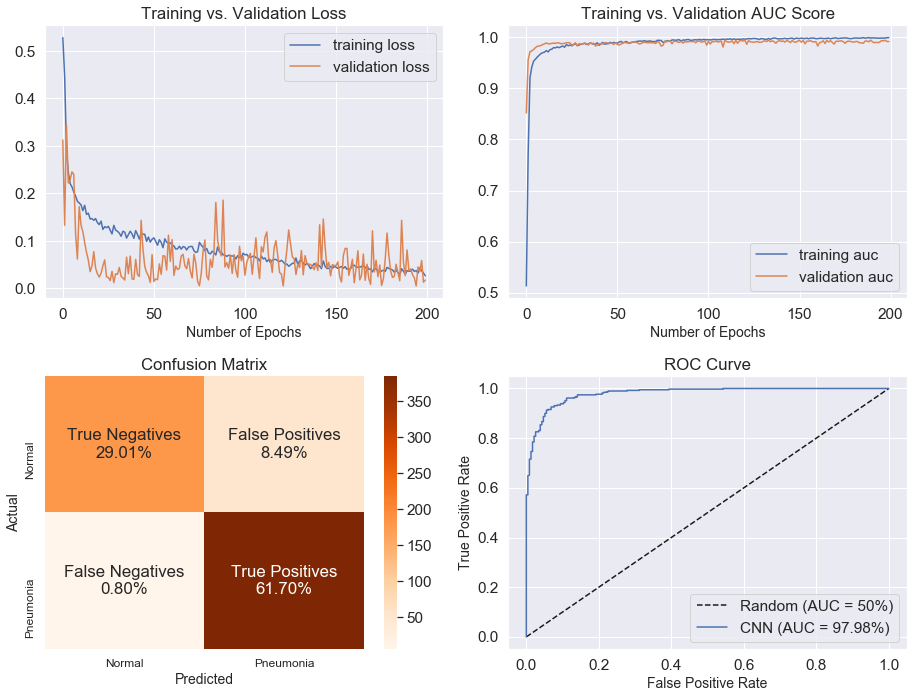

In [122]:
create_charts(cnn, cnn_model)

### Model #5

In [ ]:
## batch size: 64 Conv2D (filter: 32, 64, 128)  x 3 + different dense units + Batch Normalization
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=64, kernel_size=3))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=128, kernel_size=3))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(BatchNormalization())
cnn.add(Dense(activation='relu', units=1024))
cnn.add(Dense(activation='relu', units=512))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

[Summary Statistics]
Accuracy = 82.53% | Precision = 78.27% | Recall = 99.74% | Specificity = 53.85% | F1 Score = 87.71%


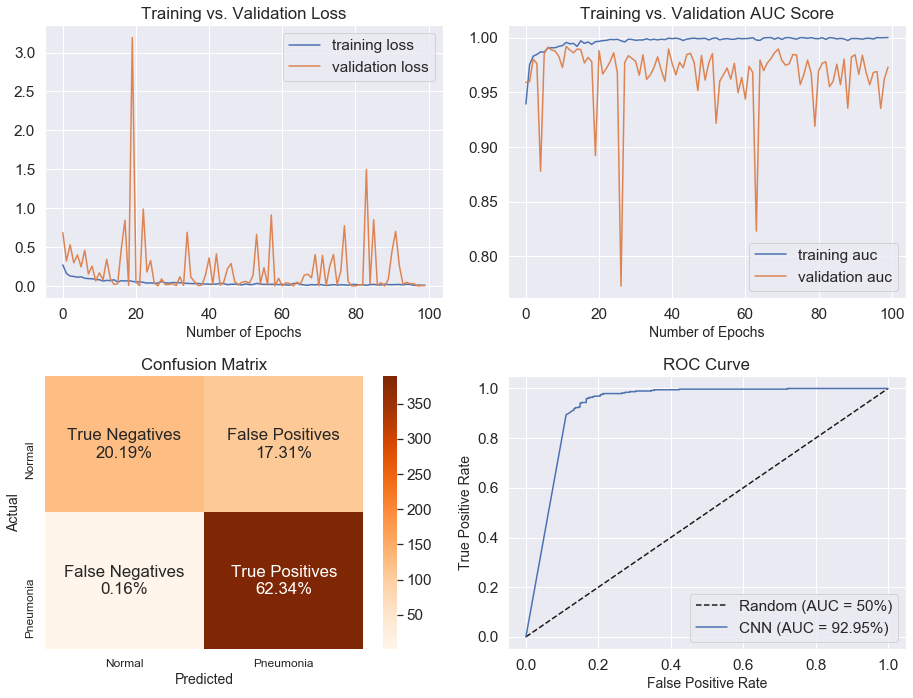

In [117]:
create_charts(cnn, cnn_model)

### Model #6

In [119]:
## Conv2D (filter: 32, 64, 128)  x 3 + different dense units + Batch Normalization + Dropout Dense layer
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='elu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(filters=64, kernel_size=3, activation='elu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.3))

cnn.add(Conv2D(filters=128, kernel_size=3, activation='elu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.3))

cnn.add(Flatten())

cnn.add(BatchNormalization())
cnn.add(Dense(activation='relu', units=512))
cnn.add(Dropout(0.25))
cnn.add(Dense(activation='relu', units=256))
cnn.add(Dropout(0.25))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

Epoch 1/100
 - 46s - loss: 0.3660 - auc_12: 0.8587 - val_loss: 0.5204 - val_auc_12: 0.9702
Epoch 2/100
 - 44s - loss: 0.2350 - auc_12: 0.9473 - val_loss: 0.4677 - val_auc_12: 0.9793
Epoch 3/100
 - 43s - loss: 0.2011 - auc_12: 0.9623 - val_loss: 0.1755 - val_auc_12: 0.9841
Epoch 4/100
 - 45s - loss: 0.1815 - auc_12: 0.9693 - val_loss: 0.2092 - val_auc_12: 0.9856
Epoch 5/100
 - 44s - loss: 0.1832 - auc_12: 0.9680 - val_loss: 0.0771 - val_auc_12: 0.9869
Epoch 6/100
 - 50s - loss: 0.1661 - auc_12: 0.9723 - val_loss: 0.1557 - val_auc_12: 0.9890
Epoch 7/100
 - 53s - loss: 0.1726 - auc_12: 0.9708 - val_loss: 0.1452 - val_auc_12: 0.9861
Epoch 8/100
 - 47s - loss: 0.1570 - auc_12: 0.9764 - val_loss: 0.1330 - val_auc_12: 0.9911
Epoch 9/100
 - 43s - loss: 0.1499 - auc_12: 0.9772 - val_loss: 0.0909 - val_auc_12: 0.9922
Epoch 10/100
 - 44s - loss: 0.1445 - auc_12: 0.9799 - val_loss: 0.0573 - val_auc_12: 0.9898
Epoch 11/100
 - 46s - loss: 0.1421 - auc_12: 0.9799 - val_loss: 0.0743 - val_auc_12: 0.99

 - 44s - loss: 0.0592 - auc_12: 0.9966 - val_loss: 0.3269 - val_auc_12: 0.9882
Epoch 91/100
 - 44s - loss: 0.0564 - auc_12: 0.9953 - val_loss: 0.1461 - val_auc_12: 0.9942
Epoch 92/100
 - 44s - loss: 0.0663 - auc_12: 0.9949 - val_loss: 0.0703 - val_auc_12: 0.9909
Epoch 93/100
 - 44s - loss: 0.0694 - auc_12: 0.9952 - val_loss: 0.0042 - val_auc_12: 0.9862
Epoch 94/100
 - 43s - loss: 0.0564 - auc_12: 0.9960 - val_loss: 0.0727 - val_auc_12: 0.9944
Epoch 95/100
 - 43s - loss: 0.0642 - auc_12: 0.9948 - val_loss: 0.2640 - val_auc_12: 0.9895
Epoch 96/100
 - 44s - loss: 0.0636 - auc_12: 0.9952 - val_loss: 0.1539 - val_auc_12: 0.9910
Epoch 97/100
 - 45s - loss: 0.0631 - auc_12: 0.9963 - val_loss: 0.0276 - val_auc_12: 0.9946
Epoch 98/100
 - 47s - loss: 0.0542 - auc_12: 0.9966 - val_loss: 0.1832 - val_auc_12: 0.9924
Epoch 99/100
 - 47s - loss: 0.0642 - auc_12: 0.9958 - val_loss: 0.0028 - val_auc_12: 0.9838
Epoch 100/100
 - 49s - loss: 0.0555 - auc_12: 0.9964 - val_loss: 0.0308 - val_auc_12: 0.9911


[Summary Statistics]
Accuracy = 89.42% | Precision = 86.49% | Recall = 98.46% | Specificity = 74.36% | F1 Score = 92.09%


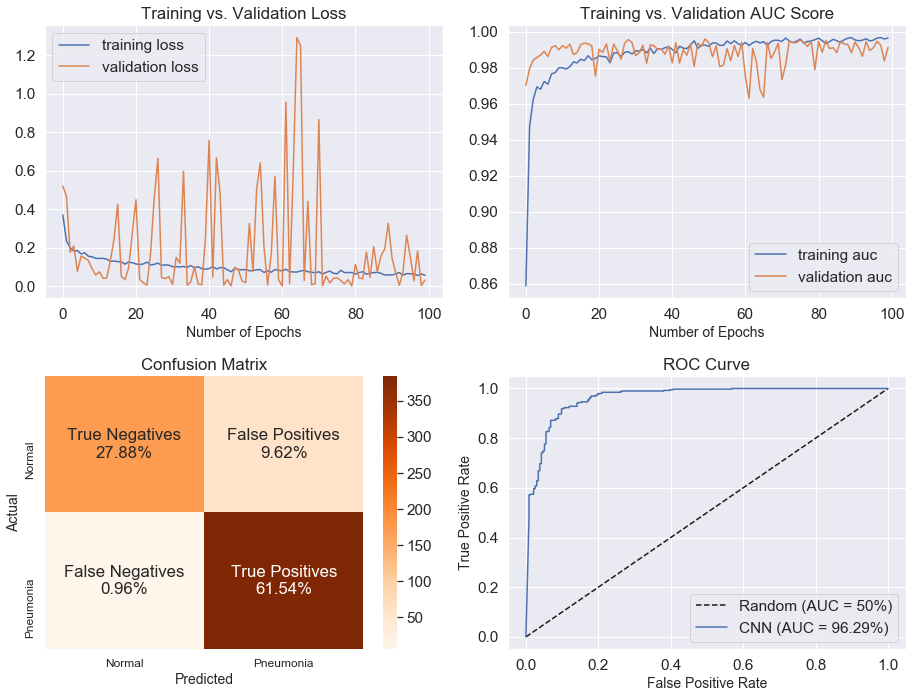

In [120]:
create_charts(cnn, cnn_model)

## Conclusion

**Model #4 (200 epochs)** has the best result with the following architecture

    cnn = Sequential()
    cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

    cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    cnn.add(Flatten())

    cnn.add(Dense(activation='relu', units=128))
    cnn.add(Dense(activation='sigmoid', units=1))

    cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
    cnn_model = cnn.fit_generator(train_generator, 
                                  steps_per_epoch = len(train_generator), 
                                  epochs = 200, 
                                  validation_data = val_generator,
                                  validation_steps = len(val_generator), 
                                  verbose=2)
                                  
                                  
 - AUC Score: 97.98%
 - Accuracy: 90.71%
 - Recall: 98.72% (FP = 8.49% and FN = 0.80%)
 
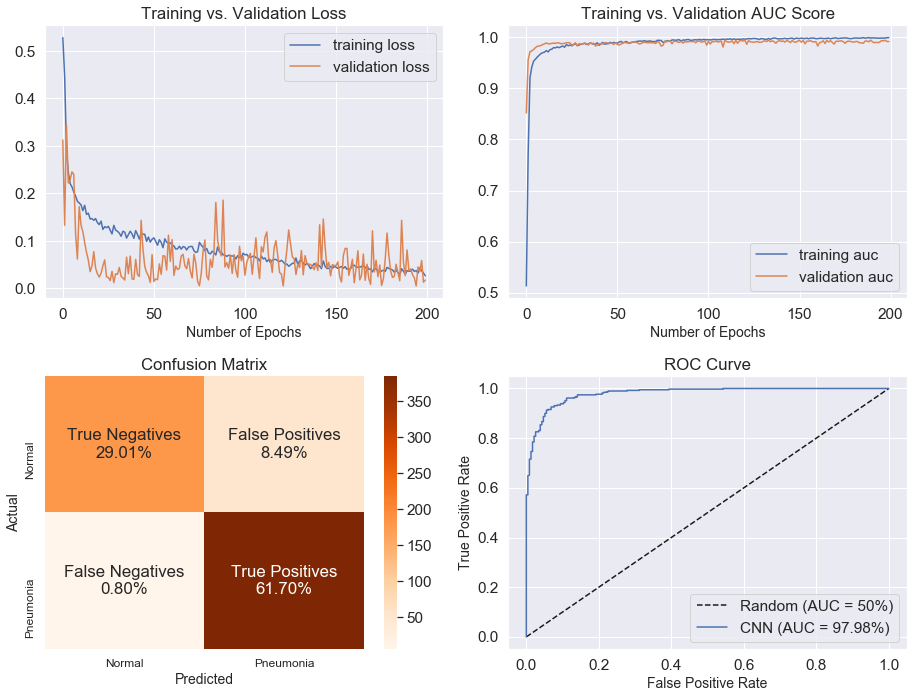